In [89]:
from importlib import reload
import sys
import re
import matplotlib.pyplot as pl
import numpy as np
import scipy
import pandas as pd
import itertools
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
import types
import umap
import sklearn.manifold
sys.path.extend(["../src", "."])

In [76]:
import dblp
import helper
reload(dblp)
reload(helper)
print("reloaded")

reloaded


In [5]:
wv = helper.load_wv_model()

Loading from cache...
Wordvector model loaded in 0.00 seconds


In [17]:
# test the word vector model
wv.similar_by_vector(wv['dog'])

[('dog', 1.0),
 ('cat', 0.8798074722290039),
 ('dogs', 0.8344309329986572),
 ('pet', 0.7449564933776855),
 ('puppy', 0.723637580871582),
 ('horse', 0.7109653353691101),
 ('animal', 0.6817063093185425),
 ('pig', 0.6554172039031982),
 ('boy', 0.6545307636260986),
 ('cats', 0.6471933126449585)]

In [7]:
# Let's load the models

In [8]:
dct = helper.load_dct("inproceedings")
model1 = helper.ldamodel("inproceedings", dct, model_name="m1")
model2 = helper.ldamodel("inproceedings", dct, model_name="m2")

In [9]:
# We get the model top words
topic_words = helper.topic_words(model2, dct, 50, keep_weights=True)
df_topic_words = pd.DataFrame(dict(x[:2] for x in topic_words))
df_topic_words.head(10)

0           1            2          3           4             5   \
0   networks        data      service      based       model         human   
1   wireless        open       design      using     control         using   
2     sensor       based   management      range       based         based   
3      based  processing     oriented  detection      models         robot   
4    network      stream      systems       data       using     detection   
5     energy  classifier        based    dynamic      people        motion   
6    routing      source       system    imaging   discovery         model   
7      multi   databases  composition     across  predictive   constraints   
8  efficient    approach        using     search    gaussian  segmentation   
9        hoc        loop      towards     camera     mixture      approach   

               6         7            8               9   ...              40  \
0           based     based        based         sensing  ...           based   
1             key     codes        using           multi  ...     recognition   
2          scheme  analysis     analysis           using  ...           using   
3           group     model       random           based  ...          speech   
4          secure   concept         data          remote  ...            face   
5  authentication  distance      wavelet            user  ...         machine   
6        networks     using       fields          supply  ...         medical   
7   communication    design   estimation           chain  ...         control   
8      encryption      form    transform   collaboration  ...  classification   
9        protocol  magnetic  conditional  classification  ...     translation   

                41                42            43            44          45  \
0            based             using      software          semi        free   
1        objective             based   engineering         based       based   
2            using             music         based    supervised  expression   
3        satellite  characterization         using         event     thermal   
4            multi          spectral       systems         using     problem   
5        algorithm    reconfigurable        change         image      shared   
6              sar            number   development    optimizing        task   
7          results            system       product  registration        gene   
8  characteristics          exchange  requirements     automatic       using   
9       perception          analysis        design     detection   languages   

              46           47         48            49  
0       learning        based      using       traffic  
1          based         role      based       network  
2          using       agents       data          game  
3         system        using      trees         based  
4  reinforcement        multi       step      networks  
5       transfer  information    network        neural  
6     evaluation          top    private         radar  
7        student        modal   parallel         multi  
8        systems     tangible  emergency        system  
9        feature       visual      price  asynchronous  

[10 rows x 50 columns]

In [10]:
topic_weights = np.array([x[-1] for x in topic_words])
topic_weights.shape

(50, 50)

In [18]:
topic_wv = helper.wv_encode(wv, [x[1] for x in topic_words])
num_topics, num_topwords, embed_dim = topic_wv.shape
topic_wv.shape

(50, 50, 100)

In [19]:
weighted_topic_wv = topic_weights.reshape(
    (num_topics, num_topwords, 1)) * topic_wv

In [29]:
T = topic_wv.sum(axis=1)
T.shape

(50, 100)

In [31]:
T_weighted = weighted_topic_wv.sum(axis=1)
T_weighted.shape

(50, 100)

In [21]:
# Let's compute a centroid, and subtract that from each
# of the topics

In [22]:
t0 = np.mean(T, axis=0)
T_zero = T - t0.reshape((1, -1))
T_zero.shape

(50, 100)

In [23]:
def v2w(v, topk=15):
    return [x[0] for x in wv.similar_by_vector(v, topk)]

In [24]:
norm = np.linalg.norm(T_zero, axis=1)
sim = (T_zero @ T_zero.T) / norm.reshape((-1, 1)) / norm.reshape((1, -1))

In [25]:
dist = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(T))

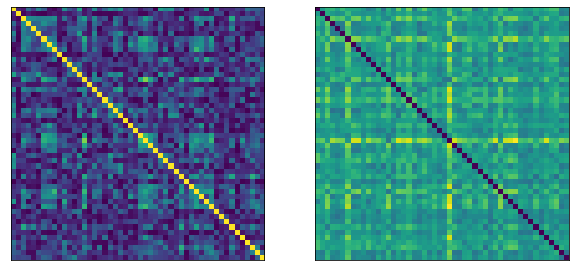

In [78]:
pl.figure(figsize=(10, 6))
pl.subplot(1,2,1)
helper.imshow(np.abs(sim))

pl.subplot(1,2,2)
helper.imshow(dist)

In [120]:
U = umap.UMAP(n_neighbors=3, random_state=7)
xy = U.fit_transform(T_zero)
pl.scatter(xy[:, 0], xy[:, 1], s=150, alpha=0.5, c='blue');

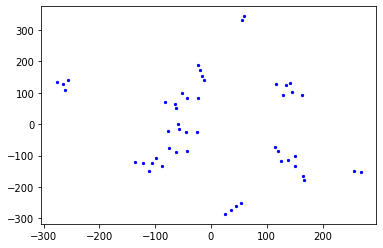

In [113]:
U = sklearn.manifold.TSNE(n_components=2, perplexity=2, random_state=2)
xy = U.fit_transform(T_zero)
pl.scatter(xy[:, 0], xy[:, 1], s=5, c='blue');